In [3]:
import numpy as np
from scipy.optimize import fminbound
import numba
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

In [4]:
# Initialization
sizek = 26
sizez = 26
alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02


In [5]:
#Creating k_grid
k_bar = (alpha*beta)**(1/(1 - alpha))
k_grid = np.linspace(0.5*k_bar, 1.5*k_bar, sizek)

#Creating z_grid

def rouwen(rho, mu, step, num):
    '''
    Adapted from Lu Zhang and Karen Kopecky. Python by Ben Tengelsen.
    Construct transition probability matrix for discretizing an AR(1)
    process. This procedure is from Rouwenhorst (1995), which works
    well for very persistent processes.

    INPUTS:
    rho  - persistence (close to one)
    mu   - mean and the middle point of the discrete state space
    step - step size of the even-spaced grid
    num  - number of grid points on the discretized process

    OUTPUT:
    dscSp  - discrete state space (num by 1 vector)
    transP - transition probability matrix over the grid
    '''

    # discrete state space
    dscSp = np.linspace(mu -(num-1)/2*step, mu +(num-1)/2*step, num).T

    # transition probability matrix
    q = p = (rho + 1)/2.
    transP = np.array([[p**2, p*(1-q), (1-q)**2], \
                    [2*p*(1-p), p*q+(1-p)*(1-q), 2*q*(1-q)], \
                    [(1-p)**2, (1-p)*q, q**2]]).T


    while transP.shape[0] <= num - 1:

        # see Rouwenhorst 1995
        len_P = transP.shape[0]
        transP = p * np.vstack((np.hstack((transP, np.zeros((len_P, 1)))), np.zeros((1, len_P+1)))) \
                + (1 - p) * np.vstack((np.hstack((np.zeros((len_P, 1)), transP)), np.zeros((1, len_P+1)))) \
                + (1 - q) * np.vstack((np.zeros((1, len_P+1)), np.hstack((transP, np.zeros((len_P, 1)))))) \
                + q * np.vstack((np.zeros((1, len_P+1)), np.hstack((np.zeros((len_P, 1)), transP))))

        transP[1:-1] /= 2.


    # ensure columns sum to 1
    if np.max(np.abs(np.sum(transP, axis=1) - np.ones(transP.shape))) >= 1e-12:
        print('Problem in rouwen routine!')
        return None
    else:
        return transP.T, dscSp
#pi = rouwen(rho, 0, sigma*(1.5)**(0.5), sizez)[0]
#z_grid = rouwen(rho, 0, sigma*(1.5)**(0.5), sizez)[1]
pi = np.transpose(rouwen(rho, 0, 10*sigma/(sizez - 1), sizez)[0])  # row is z and column is z_prime
z_grid = rouwen(rho, 0, 10*sigma/(sizez - 1), sizez)[1]

In [6]:
def u(k, z, kp1, alpha):
    utility = np.log(np.exp(z)*k**alpha - kp1)
    return utility

In [7]:
VFtol = 1e-6    #tolerance to determine convergence
VFdist = 7.0    #variable to store the distance between two Vs
VFmaxiter = 3000
V = np.ones((sizek, sizez))  # initial guess at value function
Vmat = np.ones((sizek, sizez, sizek))  # initialize Vmat matrix
#Vstore = np.zeros((sizek, sizez, VFmaxiter))  # initialize Vstore array
VFiter = 1

@numba.jit
def Vmat_iter(sizek, sizez, Vmat, u, alpha, beta, pi, V):
    '''
    ----------------------------------------------------
    Function to update the Vmat
    ----------------------------------------------------
    Input:
    sizek:
    sizez:
    Vmat:
    u:                            utility function
    beta:                         discount factor
    pi:                           transition matrix of the shock
    V:                            current value of V
    alpha:
    '''
    for i, k in enumerate(k_grid):  # loop over k
            for j, z in enumerate(z_grid):  # loop over z
                for h, kp1 in enumerate(k_grid): #loop over k'
                    Vmat[i, j, h] = u(k, z, kp1, alpha) + beta*np.dot(pi[j,:], V[h, :].reshape(sizez,))
    return Vmat

start_time = time.clock()
while (VFdist > VFtol) and (VFiter < VFmaxiter):
    TV = V
    Vmat = Vmat_iter(sizek, sizez, Vmat, u, alpha, beta, pi, V)
    #Vstore[:, :, VFiter] = V.reshape(sizek, sizez)  
    V = np.max(Vmat,axis= 2)
    PF = np.argmax(Vmat, axis= 2)
    VFdist = (np.absolute(V - TV)).max()
    VFiter += 1
    #print(VFiter, VFdist)
    

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')
VF = V
PF_vals = k_grid[PF]
benchmark =  np.empty_like(PF)
for i in range(sizek):
    benchmark[i, :] = i
benchmark_vals = k_grid[benchmark]
#intersection
x_intersect = k_grid[np.where(benchmark_vals == PF_vals)[1]]
y_intersect = z_grid[np.where(benchmark_vals == PF_vals)[0]]
z_intersect = PF_vals[benchmark_vals == PF_vals]

Value function converged after this many iterations: 687
VFI took  120.31744215231909  seconds to solve


<IPython.core.display.Javascript object>


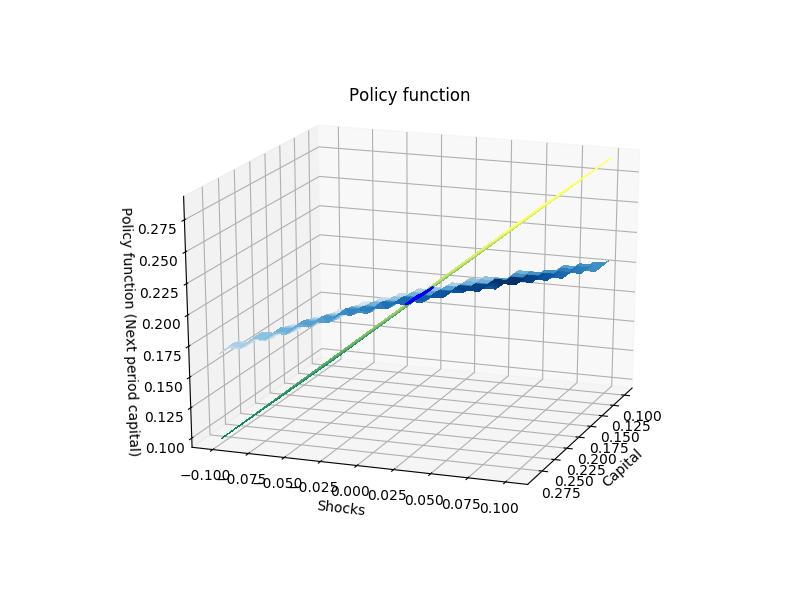

In [8]:
#plotting
kmat, zmat = np.meshgrid(k_grid, z_grid)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kmat, zmat, PF_vals, rstride=1, cstride=1, cmap=cm.Blues,
                linewidth=0, antialiased=False, zorder = 20)
ax.plot_surface(kmat, zmat, benchmark_vals, rstride=1, cstride=1, cmap=cm.summer,
                linewidth=0, antialiased=False, zorder = 1)
ax.plot(x_intersect, y_intersect, z_intersect, "b-")
ax.view_init(elev=20., azim=20)  # to rotate plot for better view
ax.set_xlabel(r'Capital')
ax.set_ylabel(r'Shocks')
ax.set_zlabel(r'Policy function (Next period capital)')
plt.title("Policy function")

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
